# Titanic Dashboard

This notebook demonstrates how to create a simple dashboard using Panel. The dashboard will display a number of visualizations based on the Titanic dataset. The dataset contains information about passengers on the Titanic, including whether they survived (see the notebook [../3-data-analysis/04_a_exploratory_data_analysis.ipynb](./../3-data-analysis/04_a_exploratory_data_analysis.ipynb), [../3-data-analysis/04_b_exploratory_data_analysis.ipynb](./../3-data-analysis/04_b_exploratory_data_analysis.ipynb) and [./3-data-analysis/04_c_exploratory_data_analysis.ipynb](./../3-data-analysis/04_c_exploratory_data_analysis.ipynb) for more information).

The dashboard will allow users to filter the data based on the:
- Name of the passenger
- Sex of the passenger
- Passenger class
- Whether the passenger survived


The dashboard will contain the following visualizations:

- A boxplot of the age of the passengers
- A violin plot of the age distribution by class
- A histogram of the age distribution
- A bar plot of the number of passengers by class
- Data table with the filtered data

The architecture of the dashboard is as follows:
![Dashboard architecture](./images/layout_and_widgets.png)

The dashboard will look like this:
![Dashboard architecture](./images/titanic_dashboard.png)




So, let's start importing the necessary libraries and loading the data.

In [4]:
import pandas as pd
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

import panel as pn
pn.extension()

from panel.theme import Material
pn.config.design = Material

Next, data is loaded.

In [5]:
def load_data():
    data = pd.read_excel('./../3-data-analysis/data/titanic/Titanic.xls')
    return data

df = load_data()

Now, we will create a number of visualizations based on the data. We will create a boxplot of the age of the passengers, a violin plot of the age distribution by class, a histogram of the age distribution, and a bar plot of the number

In [6]:
def make_age_boxplot(df):
    fig, ax = plt.subplots(figsize=(6, 1), tight_layout=True)
    df[['age']].plot.box(ax=ax, 
                         vert=False,
                         color='red')
    ax.set_title('Age', fontsize=5)
    ax.tick_params(labelsize=5)
    ax.set_xlim(0, 90)
    return fig


def make_class_age_sex_violin_plot(df):
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(5, 2))
    g = sns.violinplot(ax=ax,
                   data=df,
                   x='pclass',
                   y='age',
                   hue='sex')
    # put the legend outside the plot
    g.legend(loc='upper left',  fontsize=5)
    ax.set_title('Age distribution by class', fontsize=8)
    ax.set_xlabel('Passenger Class', fontsize=7)
    ax.set_ylabel('Age', fontsize=7)
    ax.tick_params(labelsize=5)
    
    return fig
    
def make_ages_histogram(df):
    fig, ax = plt.subplots(figsize=(5, 2))
    df['age'].plot(kind='hist',
                   ax=ax,
                   alpha=0.1,
                   bins=20,
                   color='green')
    ax.set_xlabel('Age', fontsize=7)
    ax.set_ylabel('Count', fontsize=7)
    ax.set_title('Age distribution', fontsize=8)
    ax.tick_params(labelsize=5)
    return fig

def make_survivors_by_gender_and_class(df):
    fig, ax = plt.subplots(figsize=(5, 2))
    g = df.pivot_table(index='sex',
                       values='survived', 
                       columns='pclass', 
                       aggfunc='sum').plot(kind='bar', ax=ax)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)
    ax.set_title('Survivors by gender and class', fontsize=7)
    ax.set_ylabel('Number of survivors', fontsize=7)
    ax.tick_params(labelsize=7)
    return fig

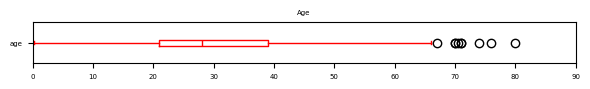

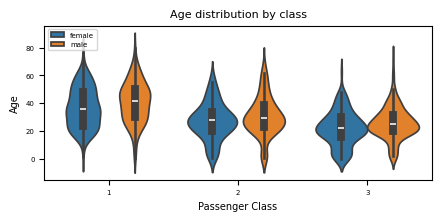

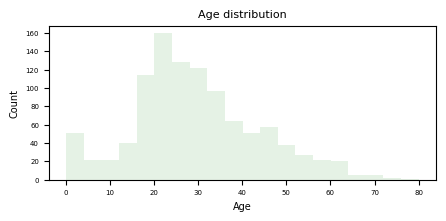

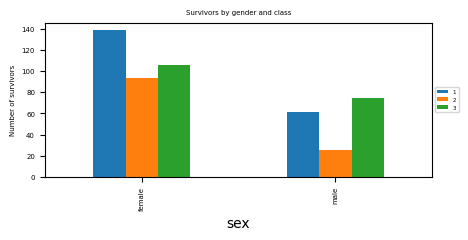

In [7]:
age_boxplot_panel = pn.pane.Matplotlib(make_age_boxplot(df), width=1200)
passenger_by_class_panel = pn.pane.Matplotlib(make_class_age_sex_violin_plot(df), width=400)
ages_hist_panel = pn.pane.Matplotlib(make_ages_histogram(df), width=400)
survivors_by_gender_and_class_panel = pn.pane.Matplotlib(make_survivors_by_gender_and_class(df), width=400)


df_panel = pn.widgets.DataFrame(df, width=1200, height=400)

data_visualization_panel = pn.layout.Column(
    age_boxplot_panel,
    pn.layout.Row(
        passenger_by_class_panel,
        ages_hist_panel,
        survivors_by_gender_and_class_panel),
    df_panel
)

In [8]:
def update_indicator(event):
    text_widgetvalue = filter_text_intput.value
    sex_widget_values = filter_sex.value # list of selected values
    passenger_class_widget_values = filter_passenger_class.value # list of selected values
    survived_widget_values = filter_survived.value # list of selected values

    # build filter based on widget values - start with all True        
    filter = pd.Series([True] * len(df))

    # filter on name
    if text_widgetvalue:
        filter = filter & df['name'].str.contains(text_widgetvalue, case=False)
    
    # filter on sex
    if sex_widget_values:
        filter = filter & df['sex'].isin(sex_widget_values)
    
    # filter on passenger class
    if passenger_class_widget_values:
        passenger_class_widget_values_as_int = [int(x) for x in passenger_class_widget_values]
        filter = filter & df['pclass'].isin(passenger_class_widget_values_as_int)  
        
    # filter on survived
    if survived_widget_values:
        survived_widget_values_as_int = [int(x) for x in survived_widget_values]
        filter = filter & df['survived'].isin(survived_widget_values_as_int)

    # filter_text_intput.value = survived_widget_values_as_int
    
    # update the DataFrame panel    
    df_panel.value = df[filter] 
    
    # update the boxplot
    age_boxplot_panel.object = make_age_boxplot(df[filter])
    
    # update the violin plot
    passenger_by_class_panel.object = make_class_age_sex_violin_plot(df[filter])
    
    # update the histogram
    ages_hist_panel.object = make_ages_histogram(df[filter])
    
    # update the survivors by gender and class plot
    survivors_by_gender_and_class_panel.object = make_survivors_by_gender_and_class(df[filter])

In [9]:
# Text filter on the passenger name & Button to apply the text filter
filter_text_intput = pn.widgets.TextInput(name='Filter Name', value='')

filter_button = pn.widgets.Button(name='Apply Filter', button_type='primary')
pn.bind(update_indicator, filter_button, watch=True)

# MultiSelect to filter on sex
filter_sex = pn.widgets.MultiSelect(name='Sex', 
                                    options=['male', 'female'], 
                                    value=['male', 'female'])
pn.bind(update_indicator, filter_sex, watch=True)

# MultiSelect to filter on passenger class
filter_passenger_class = pn.widgets.MultiSelect(name='Passenger Class', 
                                                options=['1', '2', '3'],
                                                value=['1', '2', '3'])
pn.bind(update_indicator, filter_passenger_class, watch=True)

# MultiSelect to filter if passenger survived
filter_survived = pn.widgets.MultiSelect(name='Survived', 
                                         options=[0, 1],
                                         value=[0, 1])
pn.bind(update_indicator, filter_survived, watch=True)

# Panel to hold the filter widgets
filter_panel = pn.layout.Column(
    pn.layout.Column(
        filter_text_intput,
        filter_button),
    pn.layout.Column(
        filter_sex,
        filter_passenger_class,
        filter_survived),
    styles=dict(background='WhiteSmoke')
)

Row
    [0] Column
        [0] Matplotlib(Figure, width=1200)
        [1] Row
            [0] Matplotlib(Figure, width=600)
            [1] Matplotlib(Figure, width=600)
        [2] Matplotlib(Figure, height=300, sizing_mode='fixed', width=1200)
        [3] DataFrame(height=400, sizing_mode='fixed', value=      pclass  survived    ..., width=1200)
    [1] Column
        [0] Row
            [0] TextInput(name='Filter Name')
            [1] Button(button_type='primary', name='Apply Filter')
        [1] Row
            [0] MultiSelect(name='Sex', options=['male', 'female'], value=['male', 'female'])
            [1] MultiSelect(name='Passenger Class', options=['1', '2', '3'], value=['1', '2', '3'])
            [2] MultiSelect(name='Survived', options=[0, 1], value=[0, 1])
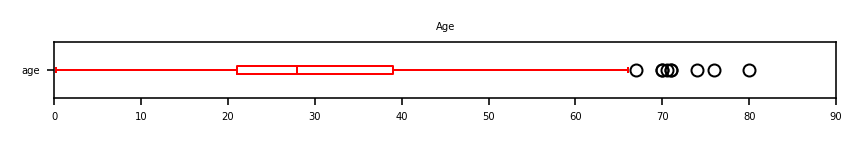
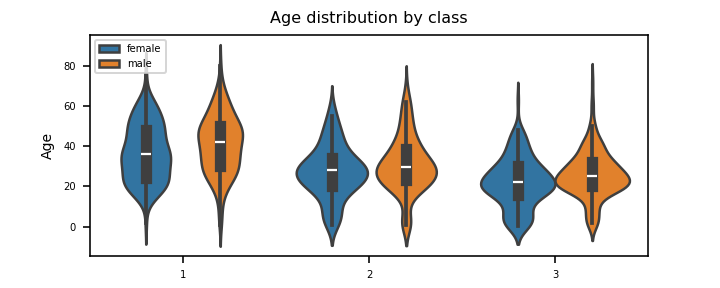
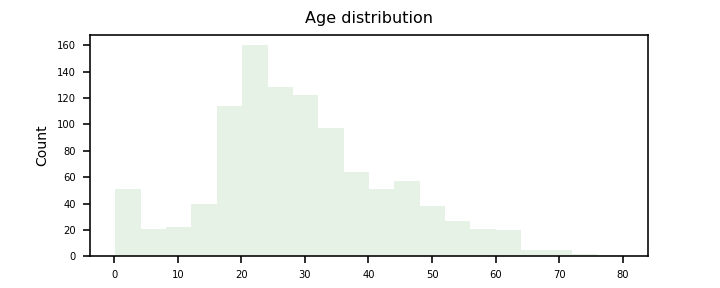
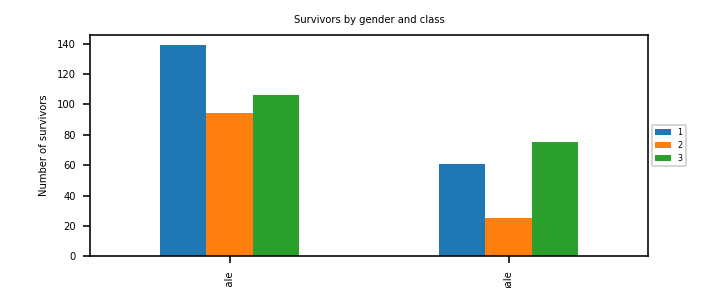

In [11]:
pn.layout.Row(
    filter_panel,
    data_visualization_panel,
).servable()